## Imports and util functions

In [106]:
import numpy as np
import shapely as sh
from uuid import uuid4
import itertools as it
from sys import modules
from time import perf_counter
from rebound import Simulation
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from multiprocessing.pool import Pool

def globalize(func):
    def wrapper(*args, **kwargs):
        return func(*args, **kwargs)
    wrapper.__name__ = wrapper.__qualname__ = uuid4().hex
    setattr(modules[wrapper.__module__], wrapper.__name__, wrapper)
    return wrapper
def HW99(mu: float, e: float, a_b: float) -> float:
    return (1.6+4.12*mu+5.1*e-4.27*mu*e
            -2.22*e**2-5.09*mu**2+4.61*e**2*mu**2)*a_b
def Ptoa(P, M):
    return np.cbrt((M)*(P/(2*np.pi*365))**2)
def atoP(a, M):
    return 2*np.pi*np.sqrt(a**3/(M))*365

## Function definitions for transit checking

In [4]:
def init(M_A: float, M_B: float, a_bin: float, a_p: float, 
         inc_bin: float, inc_p: float, Omega_bin: float = 0,
         Omega_p: float = 0, e_B: float = 0, e_p: float = 0,
         omega: float = 0) -> Simulation:
    """Returns a Simulation object of all 3 objects in the system.
    
    Parameter
    ---------
    M_A : float
        Mass of star A (solar masses)
    M_B : float
        Mass of star B (solar masses)
    a_bin : float
        Semi-major axis of binary (AU)
    a_p : float
        Semi-major axis of planet (AU)
    inc_bin : float
        Inclination of binary (rad)
    Omega_bin : float
        Longitude of ascending node of binary (rad)
    inc_p : float
        Inclination of planet (rad)
    Omega_p : float
        Longitude of ascending node of planet (rad)
    e_B : float (default 0.0)
        Orbital eccentricity of binary
    e_p : float (default 0.0)
        Orbital eccentricity of planet
    omega : float (default 0.0)
        Argument of pericenter (rad)
    """
    sim = Simulation()
    sim.add(m=M_A)
    sim.add(m=M_B, a=a_bin, inc=inc_bin, 
            Omega=Omega_bin, e=e_B, omega=omega)
    sim.add(a=a_p, inc=inc_p, Omega=Omega_p, e=e_p)
    sim.move_to_com()
    return sim

def integrate(sim: Simulation, P: float = None, N: float = None) -> tuple[np.array]:
    """Returns arrays of the x and y coordinates of the particles 
    in the Simulation object after being integrated over 'Norbits' 
    planet orbits.
    
    Parameter
    ---------
    sim : Simulation
        Simulation object
    Norbits : float (default 1.0)
        Number of planet orbits to plot
    """
    if not P:
        P = sim.calculate_orbits()[1].P
    if N:
        P *= N
    x, y, z = [[] for _ in range(sim.N)], [[] for _ in range(sim.N)], [[] for _ in range(sim.N)]
    while sim.t < P:
        sim.step()
        for i, p in enumerate(sim.particles):
            x[i].append(p.x)
            y[i].append(p.y)
            z[i].append(p.z)
    x, y, z = np.array(x), np.array(y), np.array(z)
    sim = None
    return x, y, z

def plot(sim: Simulation, x: np.array, y: np.array) -> None:
    """Returns None and plots the orbits.

    Parameter
    ---------
    sim : Simulation
        Simulation object
    x: np.array
        x-coordinates of the bodies in the system
    y: np.array
        y-coordinates of the bodies in the system
    """

    fig, ax = plt.subplots()
    for n in range(sim.N):
        ax.plot(x[n], y[n])
    ax.set_title("View of the System along the z-axis")
    ax.set_xlabel("x-coordinate")
    ax.set_ylabel("y-coordinate")
    plt.grid(True)

def plot_system(M_A: float, M_B: float, a: float, r_a: float, 
                inc: float, Omega:float = 0, e: float = 0, 
                omega: float = 0, N: float = None, dinc: float = 0) ->  None:
    """Returns None and plots the orbits.
    
    Parameter
    ---------
    M_A : float
        Mass of star A (solar masses)
    M_B : float
        Mass of star B (solar masses)
    a : float
        Semi-major axis of binary (AU)
    r_a : float
        Ratio of the planet's semi-major axis 
        and the binary's semi-major axis
    inc : float
        Inclination of binary (rad)
    Omega : float (default 0.0)
        Longitude of ascending node of binary (rad)
    e : float (default 0.0)
        Orbital eccentricity of binary
    omega : float (default 0.0)
        Argument of pericenter (rad)
    N : float (default 1.0)
        
    """
    
    sim = init(M_A, M_B, a, r_a*a, (90+inc)*np.pi/180, 
               (90+inc+dinc)*np.pi/180, Omega*np.pi/180,
               Omega*np.pi/180, e, omega=omega*np.pi/180)
    x, y, z = integrate(sim, N=N)
    plot(sim, x, y)

def check_transit(R_A: float, R_B: float, R_p: float, 
                  x: np.array, y: np.array, z: np.array) -> int:
    """Returns an int corresponding the number of stars 
    in the binary that the planet transits.

    Parameter
    ---------
    R_A : float
        Radius of star A (AU)
    R_B : float
        Radius of star B (AU)
    R_p : float
        Radius of planet (AU)
    x : np.array
        x-coordinates of the bodies in the system
    y : np.array
        y-coordinates of the bodies in the system
    """
    xy = np.transpose(np.array([[x[i], y[i]] for i in range(x.shape[0])]), 
                      axes=(0,2,1))
    shA = sh.LinearRing(xy[0])
    shB = sh.LinearRing(xy[1])
    
    Rb = max(R_A, R_B) + R_p
    bounds = np.vstack((np.array(shA.bounds).reshape(2,2), 
                        np.array(shB.bounds).reshape(2,2)))
    lb, ub = bounds.min(0)-Rb, bounds.max(0)+Rb
    x_p, y_p, z_p = x[2], y[2], z[2]
    xy_p = np.array((x_p[(x_p >= lb[0]) & (x_p <= ub[0]) & (z_p >= 0)], 
                      y_p[(x_p >= lb[0]) & (x_p <= ub[0]) & (z_p >= 0)]))
    split = []
    for j, arr in enumerate((x_p, y_p)):
        mask = np.array([arr[i] if arr[i] in xy_p[j] else 0 for i in range(arr.size)])
        split.append([list(x[1]) for x in it.groupby(mask, lambda x: x == 0) if not x[0]])
    split = np.array(split)
    results = []
    for i in range(split.shape[1]):
        xy = np.array((split[0][i], split[1][i])).T
        if xy.size <= 2:
            continue
        shp = sh.LineString(xy)
        result = int(sh.dwithin(shA, shp, R_A+R_p)) + int(sh.dwithin(shB, shp, R_B+R_p))
        results.append(result)            
    return max(results)

def transit_plot(r_A: float, r_B: float, r_p: float, I_range: tuple, 
                 a_r_range: tuple, a: float = 1, M: float = 1, mu: float = 1, 
                 Omega: float = 0, e: float = 0, omega: float = 0) -> None:
    """Returns None and creates a plot of the transit function over 
    the domain of the inclination range and the semi-major axis ratio range.
    
    Parameter
    ---------
    r_A : float
        Radius of star A (AU)
    r_B : float
        Radius of star B (AU)
    r_p : float
        Radius of planet (AU)
    I_range : tuple[float]
        Inclination range of system (rad)
    a_r_range : tuple[float]
        Ratio of the planet's semi-major axis 
        and the binary's semi-major axis
    a : float (default 1.0)
        Semi-major axis of binary (AU)
    M : float (default 1.0)
        Mass of star A (solar masses)
    mu : float (default 1.0)
        Mass ratio between stars
    Omega : float (default 0.0)
        Longitude of ascending node of system (rad)
    e : float (default 0.0)
        Orbital eccentricity of planet
    omega : float (default 0.0)
        Argument of pericenter (rad)
    """
    I = np.arange(*I_range)
    ratio = np.arange(*a_r_range)
    args = np.array(np.meshgrid(I, ratio)).T.reshape(-1,2)
    
    @globalize
    def process(args) -> int:
        i, r = args[0], args[1]
        i += 90 
        a_critical = HW99(mu/(1+mu), e, a)
        if a_critical > a*r:
            return -1
        sim = init(M, mu*M, a, a*r, i*np.pi/180, i*np.pi/180, 
                   Omega*np.pi/180, Omega*np.pi/180, 
                   e_B=e, omega=omega*np.pi/180)
        x, y, z = integrate(sim)
        
        return check_transit(r_A, r_B, r_p, x, y, z)
        
    with Pool() as pool:
        results = np.array(pool.map(process, args));
            
    def fit(grid: np.array, x: np.array, y: np.array, R: float) -> None:
        def curve(r, A):
            return A*R/r
        boundary = np.empty((0,2))
        for i, col in enumerate(grid.T):
            steps = 0
            for j, val in enumerate(col):
                if val==2:
                    steps += 1
            if not steps or steps==col.size:
                continue
            point = np.array([[x[i], y[steps-1]]])
            boundary = np.concatenate((boundary, point))
        _x, _y = boundary.T[0], boundary.T[1]
        popt, pcov = curve_fit(curve, _x, _y)
        plt.plot(x, curve(x, *popt), c='k')
        #print(popt, np.sqrt(np.diag(pcov)))

    transits = results.reshape(I.size, ratio.size)
    fig, ax = plt.subplots()
    cmap = colors.ListedColormap(['grey', 'red', 'orange', 'green'])
    boundaries = [-1.5, -0.5, 0.5, 1.5, 2.5]
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    ax.pcolormesh(ratio, I, transits, cmap=cmap, norm=norm)
    fit(transits, ratio, I, r_A+r_B) # work in progress
    plt.ylim(I.min(), I.max())
    plt.xlabel('$a_p/a_b$'); plt.ylabel('$I\ (^\circ)$')
    description = f'$e=${e}\n$\omega$={omega}$^\circ$'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, description, transform=ax.transAxes, fontsize=10,
         verticalalignment='top', bbox=props)
    plt.show()

## [WIP] Tidal Circularization

In [137]:
def fOmega(e):
    return (1+3*e**2+3/8*e**4)/(1-e**2)**(9/2)
def fOmega_e(e):
    return (1+3/2*e**2+1/8*e**4)/(1-e**2)**5
def fN(e):
    return (1+15/2*e**2+45/8*e**4+5/16*e**6)/(1-e**2)**6
def fN_e(e):
    return (1+15/4*e**2+15/8*e**4+5/64*e**6)/(1-e**2)**(13/2)
def fN_a(e):
    return (1+31/2*e**2+255/8*e**4+185/16*e**6+25/64*e**8)/(1-e**2)**(15/2)
def F_e(e):
    return (fOmega_e(e)*fN(e)/fOmega(e))-18*fN_e(e)/11
def F_a(e):
    return 4/11*(fN(e)**2/fOmega(e)-fN_a(e))
def ft_c(P, eta):
    return 0.3*(P/4)**eta
def tidal_circ(t, z, t_c):
    e, P, mu = z
    dedt = mu*(1+mu)/t_c*e*F_e(e)
    dPdt = 3*mu*(1+mu)/(2*t_c)*P*F_a(e)
    return [dedt, dPdt, 0]

N = int(1e5)
e = np.random.default_rng().beta(1.75, 2.01, N) # try APOGEE database P > 100 days
P_min, P_max = 1, 200
l = np.random.default_rng().triangular(0, 1, 1, N) # linear
P = P_max**l*P_min**(1-l)
mu = np.random.default_rng().triangular(0, 1, 1, N) # linear
inp = np.array((e, P, mu)).T

def partial(inp):
    e, P, mu = inp
    eta = 4.5
    t_age, t_c = np.random.default_rng().uniform(1, 10, 1), ft_c(P, eta)
    sol = solve_ivp(tidal_circ, (0, t_age), inp, t_eval=t_age, args=(t_c,)).y
    return sol.flatten()
with Pool() as pool:
    _e, _P, _mu = np.array(pool.map(partial, inp)).T

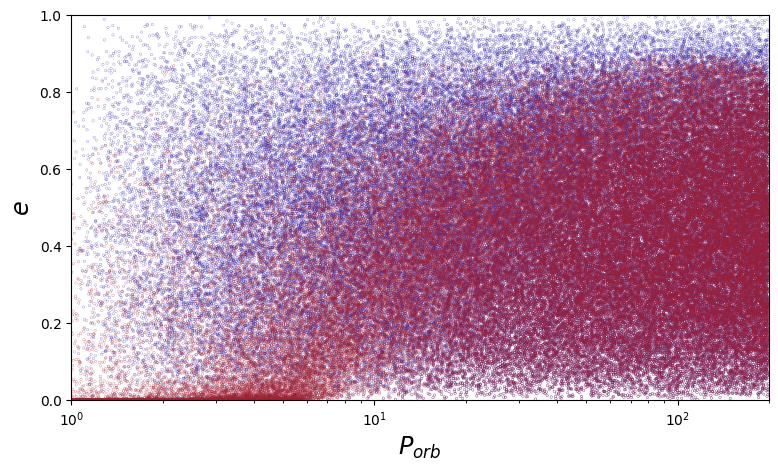

In [140]:
plt.figure(figsize=(9, 5))
plt.scatter(P, e, s=3, facecolors='none', edgecolors='#2c20ab', linewidths=0.15)
plt.scatter(_P, _e, s=3, facecolors='none', edgecolors='#a12033', linewidths=0.15)
plt.xscale('log')
plt.xlim(P_min, P_max); plt.ylim(0, 1)
plt.xlabel('$P_{orb}$', fontsize='xx-large'); plt.ylabel('$e$', fontsize='xx-large')
plt.show()

## [WIP] Function definitions and test for period sampling and transit testing

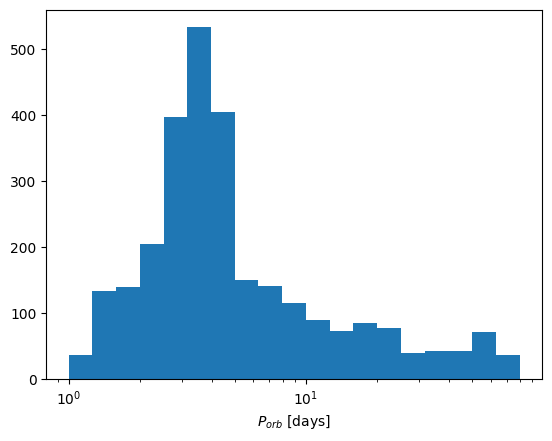

2895

In [127]:
P_orb, R, M = np.genfromtxt('PS_2023.04.03_16.15.30.csv', skip_header=14, 
                            unpack=True, delimiter=',', usecols=(1,2,3))
mask = ~(np.isnan(M)) | ~(np.isnan(R))
P_orb, R, M = P_orb[mask], R[mask], M[mask]
def MtoR(M):
    if M < 124:
        return 0.854*M**0.55
    return 11.531*M**0.01
for i in range(P_orb.size):
    if ~np.isnan(R[i]):
        continue
    R[i] = MtoR(M[i])

PERIOD_POP = P_orb[(R > 3.86) & (P_orb < 100)] 
# P_orb is sampled for planet period w radius > neptune radius
plt.hist(PERIOD_POP, bins=10**np.arange(0,2,0.1))
plt.xscale('log')
plt.xlabel('$P_{orb}$ [days]')
plt.show()
PERIOD_POP.size

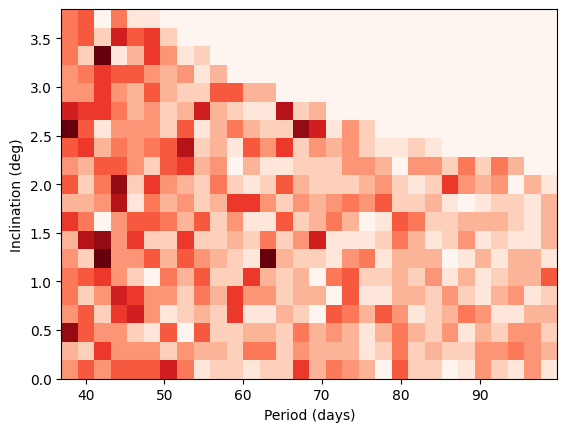

In [13]:
def period(P_c, P_upper, dist=None):
    np.random.seed()
    if P_c >= P_upper:
        raise ValueError('critial period is greater than given upper limit')
    if dist == 'test':
        return 5*P_c
    elif dist == 'uniform':
        return np.random.uniform(P_c, P_upper)
    elif dist == 'loguniform':
        return np.exp(np.random.uniform(np.log(P_c), np.log(P_upper)))
    
def sample_check(R_A, R_B, R_p, M_A, M_B, P_b, P_upper, inc):
    a_b = Ptoa(P_b, M_A + M_B)
    a_c = HW99(M_B/(M_A + M_B), 0, a_b)
    P_c = atoP(a_c, M_A + M_B)
    P_p = period(P_c, P_upper, 'loguniform')
    a_p = Ptoa(P_p, M_A + M_B)
    i = np.deg2rad(inc+90)
    sim = init(M_A, M_B, a_b, a_p, inc_bin=i, inc_p=i)
    sim.dt, BASELINE = 0.01, 8*np.pi
    x, y, z = integrate(sim, BASELINE)
    result = check_transit(R_A, R_B, R_p, x, y, z)
    if result == 2:
        return np.array([inc, P_p])
    return np.array([None]*2)

R_A, R_B, R_p, M_A, M_B, P_b, P_upper, N = 0.005, 0.005, 5e-5, 1, 1, 10, 100, 100
inp = np.repeat(np.arange(0, 4, 0.2), N)

def partial(i):
    return sample_check(R_A, R_B, R_p, M_A, M_B, P_b, P_upper, i)
with Pool() as pool:
    results = np.array(pool.map(partial, inp));

P, I = np.hsplit(results, 2)
P, I = P.flatten(), I.flatten()
P, I = P[P != None], I[I != None]
plt.hist2d(I, P, bins=(30, 20), cmap=plt.cm.Reds)
plt.xlabel('Period (days)'); plt.ylabel('Inclination (deg)')
plt.show()

In [121]:
rng = np.random.default_rng()
mu = rng.triangular(0, 1, 1) # linear
M_A, M_B = 1, mu

P_min, P_max = 1, 200
l = rng.triangular(0, 1, 1) # linear
P = P_max**l*P_min**(1-l)
e_p, e_b = 0, rng.beta(1.75, 2.01)

t_age, eta = rng.uniform(1, 10), 4.5
t_c = ft_c(P, eta)
e_b_circ, P_b_circ, _ = solve_ivp(tidal_circ, (0, t_age), (e_b, P, mu), 
                t_eval=[t_age], args=(t_c,)).y.flatten()
a_b_circ = Ptoa(P_b_circ, M_A)

def sample_period(e, mu, a):
    P = rng.choice(PERIOD_POP)
    if Ptoa(P, M_A) >= HW99(mu, e, a):
        return P
    return sample_period(e, mu, a)
a_p = Ptoa(sample_period(e_b, mu/(1+mu), a_b), M_A+M_B)

omega = rng.uniform(0, 2*np.pi)
i = np.rad2deg(np.arcsin(rng.uniform(np.sin(0, np.deg2rad(5)))))


# distributions for radii? R_A = 1 solar radius, R_B = mass radius relation, R_p = 0
# planet period before or after circ?
# check i sampling

# plot final P_b hist

motivation
david martin 2018: no periods below 6 days ??
maybe bc of circ

how CBPs are detected
diagrams: binary period changes make inclination offset more
tidal circ
e vs orb P w explanation of tides

methods
n-body sim: transit checker
transit check plots
tidal circ plots

results
agreement with expected for transit limits

questions
why sampling from radial velocity: observational selection effects, tranists strongly biased towards smaller a, still some in rv but not as bad
smaller mass planets harder to detect, more complete sample pop

## Testing...


In [ ]:
plot_system(1, 1, 1, 4, 90, e=0.5, omega=0)
plot_system(1, 1, 1, 4, 0.05, e=0.5, omega=45)

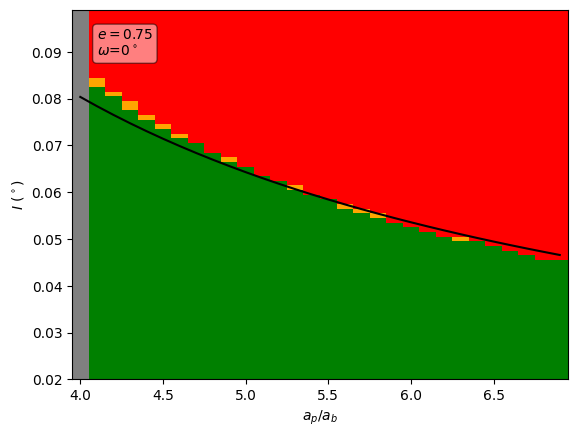

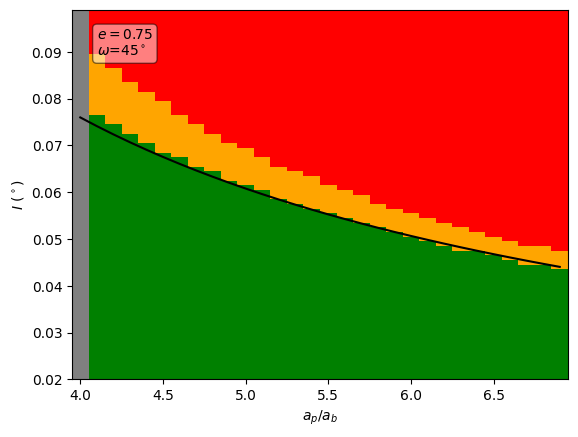

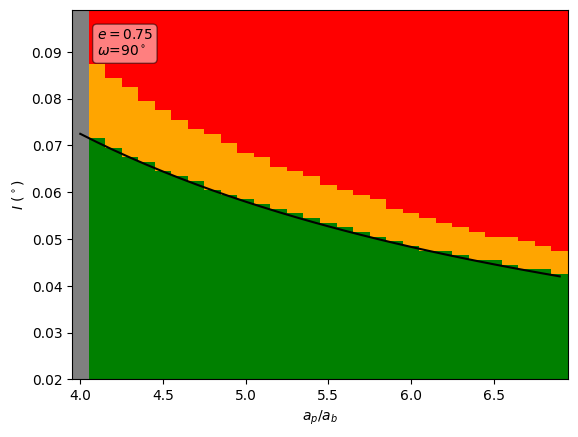

In [9]:
transit_plot(0.005, 0.005, 5e-5, 
             (0.02, 0.1, 0.001), (4, 7, 0.1), e=0.75, omega=0)
transit_plot(0.005, 0.005, 5e-5, 
             (0.02, 0.1, 0.001), (4, 7, 0.1), e=0.75, omega=45)
transit_plot(0.005, 0.005, 5e-5, 
             (0.02, 0.1, 0.001), (4, 7, 0.1), e=0.75, omega=90)

In [136]:
mask = (_e > 0.01) & (_P < 1.5)
_debug_e, _debug_P, debug_e, debug_P = _e[mask], _P[mask], e[mask], P[mask]
print(debug_e.size, debug_P[_debug_P == _debug_P.min()], debug_e[_debug_P == _debug_P.min()])

2516 [25.92325664] [0.99928892]


(array([1.02110793]), 0.7275571503570808)